Цель проекта:
Необходиомо выяснить, от каких самых малоприбыльных рейсов из Анапы мы можем отказаться в зимнее время.

Ознакомление с данными выведенных из SQL

Датасет из SQL состоит из:

model - модель самолёта
aircraft_code - модель самолета идентифицируется своим трёхзначным кодом
range - максимальная дальность полёта в километрах
seat_count - количество мест в самолете
occupancy_count - количество занятых мест пассажирами
occupancy_rate - загруженность самолета пассажирами (occupied_seats/all_seats).
flight_id - суррогатный ключ используется в качестве первичного
revenue_sum - сумма дохода от продаж билетов
city - город прибытия
airport_name - название аэропарта прибытия
longitude - долгота
latitude - широта
scheduled_departure - время вылета
scheduled_arrival - время прилета
arrival_airport - город прилета
actual_departure - фактическое время отправления
actual_arrival - фактическое время прибытия
fly_time - время полета

departure_airport (AAQ) - город вылета (Анапа) (Anapa has longitude = 37.35, latitude = 45)

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt

In [78]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

In [115]:
data = pd.read_csv('query_pavlov.csv')

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   model                118 non-null    object 
 1   aircraft_code        118 non-null    object 
 2   range                118 non-null    int64  
 3   seat_count           118 non-null    int64  
 4   occupancy_count      118 non-null    int64  
 5   occupancy_rate       118 non-null    float64
 6   flight_id            118 non-null    int64  
 7   revenue_sum          118 non-null    float64
 8   city                 118 non-null    object 
 9   airport_name         118 non-null    object 
 10  longitude            118 non-null    float64
 11  latitude             118 non-null    float64
 12  scheduled_departure  118 non-null    object 
 13  scheduled_arrival    118 non-null    object 
 14  arrival_airport      118 non-null    object 
 15  actual_departure     118 non-null    obj

In [118]:
data.sample(5)

,model,aircraft_code,range,seat_count,occupancy_count,occupancy_rate,flight_id,revenue_sum,city,airport_name,longitude,latitude,scheduled_departure,scheduled_arrival,arrival_airport,actual_departure,actual_arrival,fly_time
48,Boeing 737-300,733,4200,130,124,0.953846,136436,1811600.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-26T10:05:00Z,2017-01-26T11:45:00Z,SVO,2017-01-26T10:08:00Z,2017-01-26T11:47:00Z,0 years 0 mons 0 days 1 hours 39 mins 0.00 secs
13,Boeing 737-300,733,4200,130,118,0.907692,136181,1689600.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-31T10:05:00Z,2017-01-31T11:45:00Z,SVO,2017-01-31T10:05:00Z,2017-01-31T11:44:00Z,0 years 0 mons 0 days 1 hours 39 mins 0.00 secs
57,Boeing 737-300,733,4200,130,106,0.815385,136485,1520000.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-27T10:05:00Z,2017-01-27T11:45:00Z,SVO,2017-01-27T10:07:00Z,2017-01-27T11:47:00Z,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs
100,Sukhoi Superjet-100,SU9,3000,97,79,0.814433,136844,575100.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-02-28T09:25:00Z,2017-02-28T10:15:00Z,EGO,2017-02-28T09:26:00Z,2017-02-28T10:16:00Z,0 years 0 mons 0 days 0 hours 50 mins 0.00 secs
74,Sukhoi Superjet-100,SU9,3000,97,87,0.896907,136666,664500.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-02-09T09:25:00Z,2017-02-09T10:15:00Z,EGO,2017-02-09T09:26:00Z,2017-02-09T10:16:00Z,0 years 0 mons 0 days 0 hours 50 mins 0.00 secs


Какие самолеты куда летят и по сколько рейсов?

In [119]:
data.groupby(['city', 'model']).flight_id.count()

city      model              
Belgorod  Sukhoi Superjet-100    59
Moscow    Boeing 737-300         59
Name: flight_id, dtype: int64

Создание дополнительных признаков

Самая простая модель оценки прибыльности: стоимость билетов - стоимость топлива на рейс (для оценки последнего вам необходим километраж рейса или длительность полета).

Считаем расстояние между городами.
Зная широту и долготу аэропортов можем посчитать расстояние между ними. Для этого используем формулу Хаверсина.

In [120]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])   # переводим градусы в радианы.
    lon = lon2 - lon1
    lat = lat2 - lat1
    a = sin(lat/2)**2 + cos(lat1) * cos(lat2) * sin(lon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return round(c * earth_radius, 2)

In [121]:
# создадим новый признак - расстояние между городами
data['distance'] = data.apply(lambda row: 
                                      haversine(lon1 = 37.35, 
                                                lat1 = 45,
                                                lon2 = row['longitude'], 
                                                lat2 = row['latitude']), 
                                      axis=1)

Добавим расход топлива из внешних источников для каждой модели самолета
https://en.wikipedia.org/wiki/Fuel_economy_in_aircraft

Расход топлива на километр
Boeing 737-300           3.49 kg/km
Sukhoi Superjet-100      2.81 kg/km

In [122]:
# функция для расчета расхода топлива для каждого полета
def fuel_consumption(aircraft_code, distance):
    B737 = 3.49
    SSJ = 2.81
    if aircraft_code == '733':
        return distance*B737
    return distance*SSJ

In [123]:
# новый признак - расхода топлива на полет
data['fuel_consumption'] = data.apply(lambda row:
                                 fuel_consumption(row['aircraft_code'],
                                                  row['distance']), 
                                 axis=1)

Стоимость авиационого керасина: на январь 2017: 41.45/литр (c НДС), на февраль 2017: 39,55/литр; декабрь 2017 года: 47.1/литр (c НДС)

Считаем прибыльность рейса:
стоимость билетов(sum_amount) - стоимость топлива на рейс(fuel_burn)

In [124]:
data.actual_departure = pd.to_datetime(data.actual_departure) # переведем в нужный формат времени

In [125]:
# функция для расчета прибыли с рейса
def profit(revenue_sum, fuel_consumption, actual_departure):
    dec = 47.1                                               # стоимость топлива в декабре 
    jan = 41.45                                              # стоимость топлива январь, ферваль
    feb = 39.55                                              # стоимость топлива январь, ферваль
    if actual_departure.month == 12:
        return round(revenue_sum - fuel_consumption*dec, 3)
    elif actual_departure.month == 1:
        return round(revenue_sum - fuel_consumption*jan, 3)
    else:
        return round(revenue_sum - fuel_consumption*feb, 3)

In [126]:
# новый признак - прибыль с полета
data ['profit'] = data.apply(lambda row:
                            profit(row['revenue_sum'],
                                   row['fuel_consumption'],
                                   row['actual_departure']),
                            axis = 1)

In [127]:
data.sample(5)

,model,aircraft_code,range,seat_count,occupancy_count,occupancy_rate,flight_id,revenue_sum,city,airport_name,longitude,latitude,scheduled_departure,scheduled_arrival,arrival_airport,actual_departure,actual_arrival,fly_time,distance,fuel_consumption,profit
55,Boeing 737-300,733,4200,130,120,0.923077,136471,1762800.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-17T10:05:00Z,2017-01-17T11:45:00Z,SVO,2017-01-17 10:11:00+00:00,2017-01-17T11:51:00Z,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,1220.11,4258.1839,1586298.277
14,Boeing 737-300,733,4200,130,104,0.800000,136185,1520000.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-14T10:05:00Z,2017-01-14T11:45:00Z,SVO,2017-01-14 10:06:00+00:00,2017-01-14T11:49:00Z,0 years 0 mons 0 days 1 hours 43 mins 0.00 secs,1220.11,4258.1839,1343498.277
8,Boeing 737-300,733,4200,130,115,0.884615,136159,1700600.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-01-04T10:05:00Z,2017-01-04T11:45:00Z,SVO,2017-01-04 10:07:00+00:00,2017-01-04T11:45:00Z,0 years 0 mons 0 days 1 hours 38 mins 0.00 secs,1220.11,4258.1839,1524098.277
75,Sukhoi Superjet-100,SU9,3000,97,95,0.979381,136669,752700.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-01-17T09:25:00Z,2017-01-17T10:15:00Z,EGO,2017-01-17 09:26:00+00:00,2017-01-17T10:17:00Z,0 years 0 mons 0 days 0 hours 51 mins 0.00 secs,630.11,1770.6091,679308.253
50,Boeing 737-300,733,4200,130,128,0.984615,136441,1837200.0,Moscow,Sheremetyevo International Airport,37.414600,55.972599,2017-02-03T10:05:00Z,2017-02-03T11:45:00Z,SVO,2017-02-03 10:07:00+00:00,2017-02-03T11:47:00Z,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,1220.11,4258.1839,1668788.827


<AxesSubplot:title={'center':'Средняя прибыль по городам в млн'}, xlabel='city'>

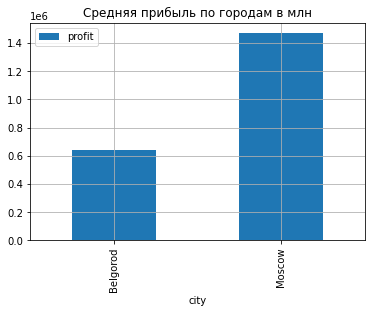

In [128]:
data.pivot_table(values='profit', index='city', aggfunc='mean').plot(kind='bar', grid=True, title='Средняя прибыль по городам в млн')

На графике видно, что рейсы на Белгород менее выгодные.

In [129]:
data.groupby('city')['profit'].mean()

city
Belgorod    6.386404e+05
Moscow      1.469914e+06
Name: profit, dtype: float64

In [130]:
mos = data[data['city'] == 'Moscow'].groupby(by='city')['profit'].mean().values[0]
bel =   data[data['city'] == 'Belgorod'].groupby(by='city')['profit'].mean().values[0]
mean_profit = (mos + bel)/2
profit_ratio = (mos / bel)
print(f'Средняя прибыль рейса на Москву - {round(mos/1000000, 3)} млн.рублей', 
      f'\nСредняя прибыль на Белгород - {round(bel/1000000, 3)} млн.рублей', 
      f'\nСредняя прибыль всех рейсов {round(mean_profit/1000000, 3)} млн.рублей',
      f'\nВ {round(profit_ratio, 2)} полеты в Белгород менее выгодные')

Средняя прибыль рейса на Москву - 1.47 млн.рублей 
Средняя прибыль на Белгород - 0.639 млн.рублей 
Средняя прибыль всех рейсов 1.054 млн.рублей 
В 2.3 полеты в Белгород менее выгодные


Какие месяцы для полетов наменее выгодные для комании

<AxesSubplot:xlabel='month'>

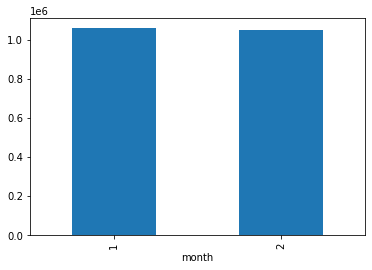

In [178]:
data.groupby('month')['profit'].mean().sort_values(ascending=False).plot(kind='bar')

In [183]:
data.groupby('month')['profit'].mean().sort_values(ascending=False)

month
1    1.057984e+06
2    1.050173e+06
Name: profit, dtype: float64

По дням недели

<AxesSubplot:xlabel='weekdays'>

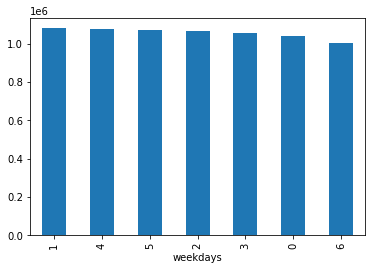

In [182]:
data.groupby('weekdays')['profit'].mean().sort_values(ascending=False).plot(kind='bar')

In [184]:
data.groupby('weekdays')['profit'].mean().sort_values(ascending=False)

weekdays
1    1.079765e+06
4    1.078311e+06
5    1.070454e+06
2    1.064848e+06
3    1.053117e+06
0    1.037299e+06
6    1.001660e+06
Name: profit, dtype: float64

Посмотрим загруженность рейсов графиком BoxPlot

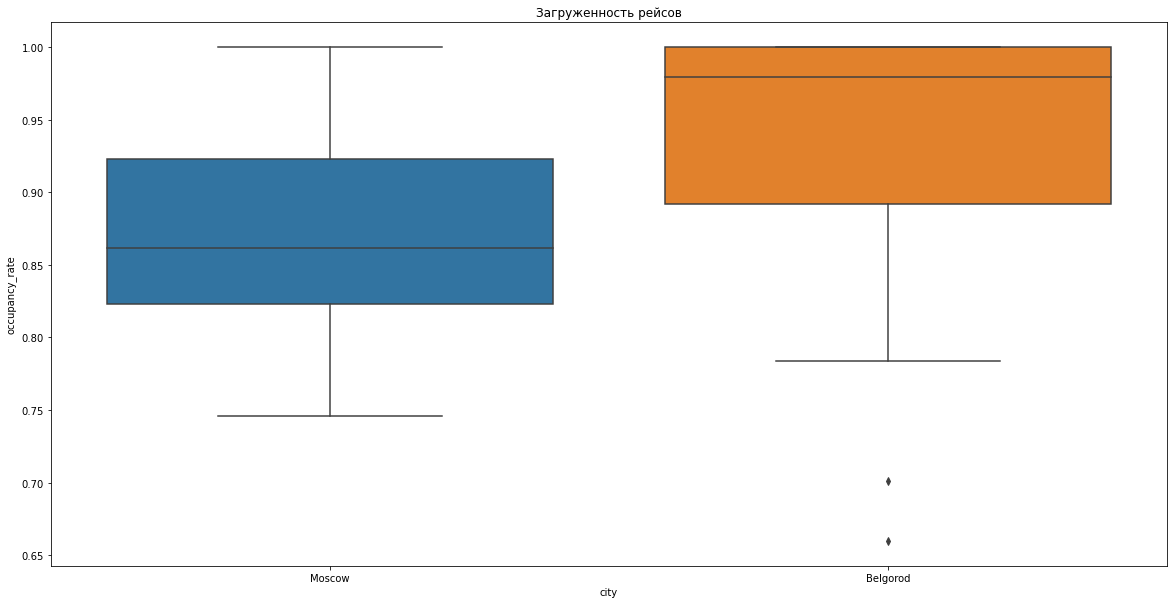

In [133]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='city', y='occupancy_rate',
                data=data,
                ax=ax)
plt.xticks(rotation=0)
ax.set_title('Загруженность рейсов')
plt.show()

In [188]:
data.groupby('city')['occupancy_rate'].mean().sort_values(ascending=False)

city
Belgorod    0.929757
Moscow      0.870143
Name: occupancy_rate, dtype: float64

Из графика видно, что 2 рейса в белгород являются выбросами. Выясним что это за рейсы

In [140]:
data[(data.occupancy_rate < 0.75) & (data.city == 'Belgorod')]

,model,aircraft_code,range,seat_count,occupancy_count,occupancy_rate,flight_id,revenue_sum,city,airport_name,longitude,latitude,scheduled_departure,scheduled_arrival,arrival_airport,actual_departure,actual_arrival,fly_time,distance,fuel_consumption,profit,month,weekdays
68,Sukhoi Superjet-100,SU9,3000,97,64,0.659794,136642,531000.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-01-30T09:25:00Z,2017-01-30T10:15:00Z,EGO,2017-01-30 09:28:00+00:00,2017-01-30T10:17:00Z,0 years 0 mons 0 days 0 hours 49 mins 0.00 secs,630.11,1770.6091,457608.253,1,0
93,Sukhoi Superjet-100,SU9,3000,97,68,0.701031,136807,531000.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,EGO,2017-02-23 09:28:00+00:00,2017-02-23T10:18:00Z,0 years 0 mons 0 days 0 hours 50 mins 0.00 secs,630.11,1770.6091,460972.410,2,3


Первый рейс: вылет 30 января в понедельник.
Второй рейс: вылет 23 февраля в четверг.
Выясним, были ли в этот день еще рейсы в Белгород

In [157]:
data['date'] = data['actual_departure'].dt.date

In [162]:
data.date = pd.to_datetime(data.date) # переведем в нужный формат времени

In [165]:
data[((data.date == '2017-01-30') | (data.date == '2017-02-23')) & (data.city == 'Belgorod')]

,model,aircraft_code,range,seat_count,occupancy_count,occupancy_rate,flight_id,revenue_sum,city,airport_name,longitude,latitude,scheduled_departure,scheduled_arrival,arrival_airport,actual_departure,actual_arrival,fly_time,distance,fuel_consumption,profit,month,weekdays,date
68,Sukhoi Superjet-100,SU9,3000,97,64,0.659794,136642,531000.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-01-30T09:25:00Z,2017-01-30T10:15:00Z,EGO,2017-01-30 09:28:00+00:00,2017-01-30T10:17:00Z,0 years 0 mons 0 days 0 hours 49 mins 0.00 secs,630.11,1770.6091,457608.253,1,0,2017-01-30
93,Sukhoi Superjet-100,SU9,3000,97,68,0.701031,136807,531000.0,Belgorod,Belgorod International Airport,36.590099,50.643799,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,EGO,2017-02-23 09:28:00+00:00,2017-02-23T10:18:00Z,0 years 0 mons 0 days 0 hours 50 mins 0.00 secs,630.11,1770.6091,460972.410,2,3,2017-02-23


In [ ]:
Других рейсов в этот день в Белгород не было

Найдем 2-3 самых малоприбыльных рейсов в Москву

In [175]:
data[(data.occupancy_rate < 0.75) & (data.city == 'Moscow')]

,model,aircraft_code,range,seat_count,occupancy_count,occupancy_rate,flight_id,revenue_sum,city,airport_name,longitude,latitude,scheduled_departure,scheduled_arrival,arrival_airport,actual_departure,actual_arrival,fly_time,distance,fuel_consumption,profit,month,weekdays,date
2,Boeing 737-300,733,4200,130,97,0.746154,136122,1431000.0,Moscow,Sheremetyevo International Airport,37.4146,55.972599,2017-01-08T10:05:00Z,2017-01-08T11:45:00Z,SVO,2017-01-08 10:08:00+00:00,2017-01-08T11:48:00Z,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,1220.11,4258.1839,1254498.277,1,6,2017-01-08
38,Boeing 737-300,733,4200,130,97,0.746154,136360,1455400.0,Moscow,Sheremetyevo International Airport,37.4146,55.972599,2017-02-05T10:05:00Z,2017-02-05T11:45:00Z,SVO,2017-02-05 10:08:00+00:00,2017-02-05T11:48:00Z,0 years 0 mons 0 days 1 hours 40 mins 0.00 secs,1220.11,4258.1839,1286988.827,2,6,2017-02-05
